In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('Pre-processed Dataset/train.csv', encoding='latin-1', index_col=0)
test = pd.read_csv('Pre-processed Dataset/test.csv', encoding='latin-1', index_col=0)

In [ ]:
train['text'] = train['text'].values.astype(str)
test['text'] = test['text'].values.astype(str)

In [ ]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('Word2Vec Embedding/word2vec_cbow_50.model')
model_ug_sg = KeyedVectors.load('Word2Vec Embedding/NLP_Dataset/word2vec_sg_50.model')

In [ ]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

In [ ]:
# embeddings_index

{'menyrbie': array([-1.17570767e-02, -1.33379027e-02,  6.16337871e-03, -5.50727127e-03,
        -1.05260583e-02, -1.06874132e-03, -2.45029060e-03, -1.19409841e-02,
        -2.21492928e-02,  3.23665291e-02,  4.94129676e-03, -6.30336255e-03,
        -7.58200476e-04, -1.02041494e-02, -8.71793646e-03,  6.23270264e-03,
        -2.95329150e-02, -4.22285451e-03, -1.19410013e-03, -1.87744852e-02,
        -7.44234445e-03, -1.93454400e-02,  6.39173109e-03,  2.53691035e-03,
         5.86780114e-03, -5.26777050e-03, -7.70597812e-03,  1.85024692e-06,
         6.01191213e-03, -1.25752902e-03,  1.58825424e-02, -5.92647644e-04,
        -3.81771359e-03,  3.15143652e-02, -6.97808200e-03, -2.92946398e-02,
        -3.93193169e-03,  1.60567202e-02,  1.20537542e-02,  3.20410356e-03,
        -4.73476155e-03,  8.22368776e-04,  1.98082551e-02, -2.01568920e-02,
         4.46957594e-04, -1.48947835e-02,  2.98264949e-03,  5.59559651e-03,
         1.42218247e-02, -1.77920628e-02,  7.37058790e-03, -1.02662351e-02,


In [ ]:
# Tokenize words
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(train.text)

In [ ]:
X_train = tokenizer.texts_to_sequences(train.text)
X_test  = tokenizer.texts_to_sequences(test.text)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
y_train_1 = train['senti'].values.astype(int)
y_test_1 = test['senti'].values.astype(int)

In [ ]:
# One-hot encoding the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train_1)
y_test = to_categorical(y_test_1)

In [ ]:
 # Pad sequences with zeros
from keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=41)
X_test = pad_sequences(X_test, padding='post', maxlen=41)

In [ ]:
embedding_dim = 100

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8799330990674415

In [ ]:
from keras.models import Sequential
from keras import layers

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=41))
model.add(layers.Conv1D(200, 3, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 100)           5919200   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 200)           60200     
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 5,981,443
Trainable params: 5,981,443
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9966
Testing Accuracy:  0.7141


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

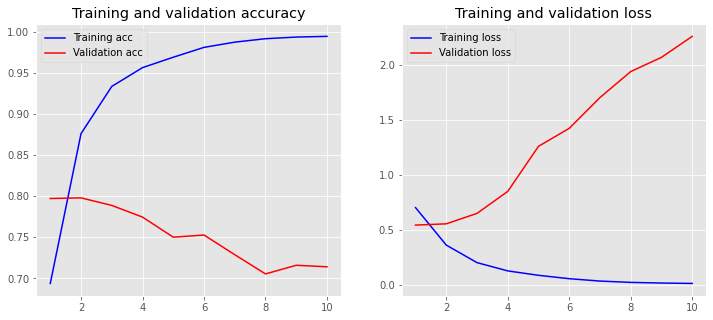

In [ ]:
plot_history(history)